# Computational Vision - Laboratory

==============================================================================================
## Practice 7: Image Segmentation

==============================================================================================

The main topics are:

1)	Segmentation of video shots with static scenes.

2) Background substraction.

3)	Segmentation of images.

In order to successfuly complete this practicum it is necessary to understand the following theory concepts: background substraction, K-means clustering, etc.

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.

Read and visualize the sequence of images "sequences"

Hint: In order to read a  collection of images, we wil use the function animation.FuncAnimation [https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.animation.FuncAnimation.html].

Observe in the following example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

<IPython.core.display.Javascript object>


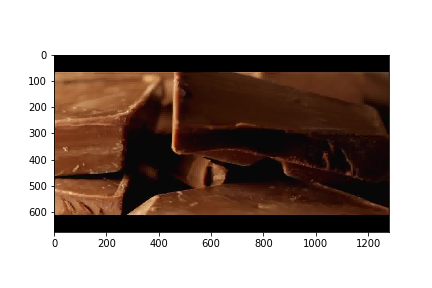

In [66]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from skimage import io

ic = io.ImageCollection('sequences/*.jpg') # Reading a sequence of images from a folder

%matplotlib notebook
%matplotlib notebook

i=0                                   # Inicializing the video display
fig = plt.figure()                    # Create figure
im = plt.imshow(ic[i], animated=True) # Visualize the first image

def updatefig1(i):                    # Updating the frame visualization
    im.set_array(ic[i*5])             # Changing the content of the canvas
    return im                         # to return a tuple!

ani = animation.FuncAnimation(fig, updatefig1, interval=5, blit=False, frames=50, repeat=False)

a) Find where a shot (scene) finishes and the following starts (boundaries). Each of the scenes in a video is usually called 'shot'. Which measure can be used in order to visually distinguish the shots in a plot? Explain your solution.

Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/shot_detection.png">

**Hint:** take the following example of video and temporal plot visualization as a template. The plot must be replaced by a frame by frame measure to be defined by you, being applicable to distinguish the shots.

- If you need to convert the image to float, the command is: img_as_float()
- If you need the histogram, it is in skimage.exposure

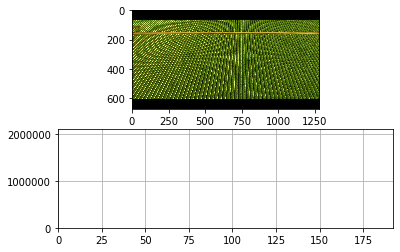

In [154]:
def get_channel_hists(image):
    image = skimage.img_as_float(image)
    r_hist, _ = skimage.exposure.histogram(image[:,:,0])
    g_hist, _ = skimage.exposure.histogram(image[:,:,1])
    b_hist, _ = skimage.exposure.histogram(image[:,:,2])
    return r_hist, g_hist, b_hist

histogram_differences = []
prev_frame = ic[0]
prev_r_hist, prev_g_hist, prev_b_hist = get_channel_hists(prev_frame)
for i in range(len(ic)):
    current_frame = ic[i]
    current_r_hist, current_g_hist, current_b_hist = get_channel_hists(current_frame)

    diff_r_hist = np.abs(current_r_hist - prev_r_hist)
    diff_g_hist = np.abs(current_g_hist - prev_g_hist)
    diff_b_hist = np.abs(current_b_hist - prev_b_hist)
    y = (diff_r_hist + diff_g_hist + diff_b_hist).sum()
    
    prev_r_hist, prev_g_hist, prev_b_hist = current_r_hist, current_g_hist, current_b_hist
    
    histogram_differences.append(y)


# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
ln, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(0, max(histogram_differences)*1.1)
ax2.set_xlim(0, len(histogram_differences))
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(i):
    xdata.append(i)
    ydata.append(histogram_differences[i])
    ln.set_data(xdata, ydata)

    # Plot image on top row
    ax1.imshow(ic[i])

    return ln,

ani = animation.FuncAnimation(fig, run, frames=len(histogram_differences), blit=True, interval=10, repeat=False)
plt.show()

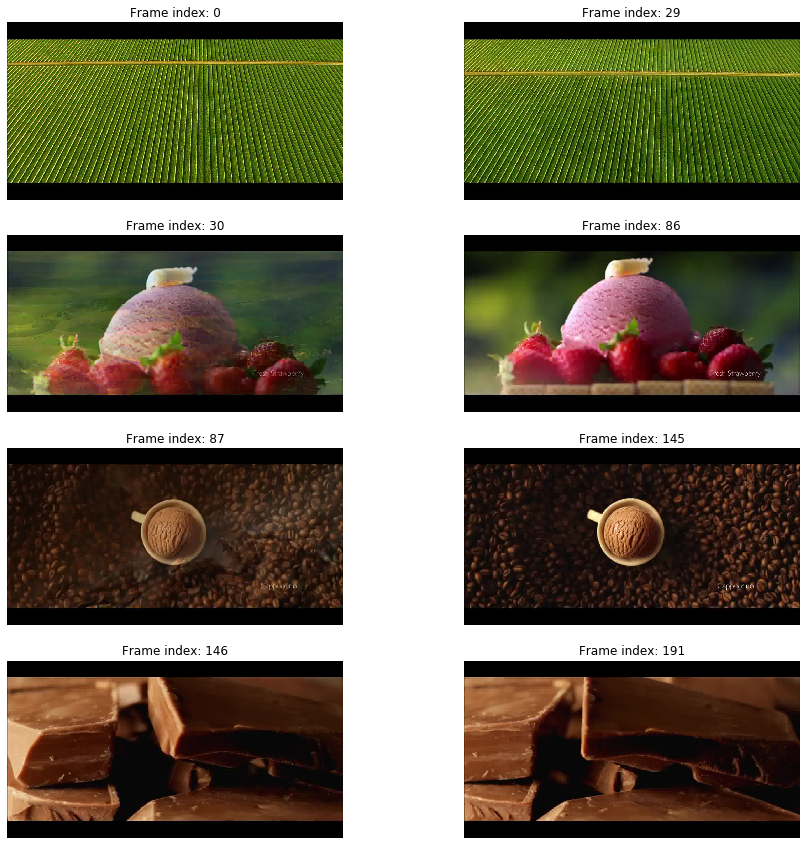

In [71]:
%matplotlib inline

threshold = 1500000
first_last_frames_shot = [0]
for i, histogram_diff in enumerate(histogram_differences):
    if histogram_diff > threshold:
        first_last_frames_shot.append(i-1)
        first_last_frames_shot.append(i)
first_last_frames_shot.append(len(histogram_differences) - 1)

f, ax = plt.subplots(4, 2, figsize=(15, 15))

for i, frame_index in enumerate(first_last_frames_shot):
    ax[divmod(i, 2)].imshow(ic[frame_index])
    ax[divmod(i, 2)].set_title(f'Frame index: {frame_index}')
    ax[divmod(i, 2)].axis('off')
    
plt.show()

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

- **Comments on our solution**

As hinted by the assignment, we compute the histogram of each frame. In our case, for checking whether two histograms belong to the same shot, we compute the absolute value of their difference. There are some approaches for accounting that images belong to the RGB space. Specifically, we separately compute the histograms for each channel, then do the subtraction channel by channel (and get the absolute values), and sum the three of them, as in [1]. Finally, we sum all the values of the resulting vector into a single scalar, which will be our measure.

In [1], it is posited that "histogram difference is less sensitive to subtle motion and is an effective measure for detecting similarity in images. By detecting significant changes in the weighted color histogram of two images, we form a more robust measure for image correspondence".

An histogram is a way of representing an image in a way more compact and uniform way, but by loosing information. It is more robust to changes. For instance, a measure based on directly subtracting the images, instead of their histograms, would probably be way more noise due to small changes (eg. an object moving to the neighbour pixel).

The problem, however, could be that the histogram still varied too much within a single scene, if there were many movements and changes, for instance. However, in the video that we have been told to use, this is not so much the case, and it can be handled by setting a big enough threshold upon which the shot is consider to change. 

[1] Histogram Difference: https://www.sciencedirect.com/topics/engineering/histogram-difference



</div>

## 7.2 Background substraction

Apply the background substraction algorithm (check theory material).

Visualize, for each shot of the video:
    1) images belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: 
You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

In [152]:
from skimage import img_as_float64

def get_background(frames):
    frames = io.collection.concatenate_images(frames)
    median_over_time = np.median(frames, axis=0).astype(np.uint8)
    return img_as_float64(median_over_time)
    
def build_background_mask(image, background, threshold=0.15):
    difference = np.abs(image - background)
    return difference < threshold

def subtract_background(image, background):
    mask = build_background_mask(image, background)
    foreground_image = image.copy()
    foreground_image[mask] = 0
    return foreground_image

In [192]:
images_to_display = []
scene_backg_to_display = []
backgrounds_to_display = []
foregrounds_to_display = []

i = 0
while i < len(first_last_frames_shot):
    first_frame_idx = first_last_frames_shot[i]
    last_frame_idx = first_last_frames_shot[i + 1]
    
    scene_background = get_background(ic[first_frame_idx:last_frame_idx+1])
    
    for j in range(first_frame_idx, last_frame_idx + 1):
        current_img = img_as_float64(ic[j])
        foreground = subtract_background(current_img, scene_background)
        background = current_img - foreground
        
        images_to_display.append(current_img)
        scene_backg_to_display.append(scene_background)
        backgrounds_to_display.append(background)
        foregrounds_to_display.append(foreground)
    
    i += 2

<IPython.core.display.Javascript object>


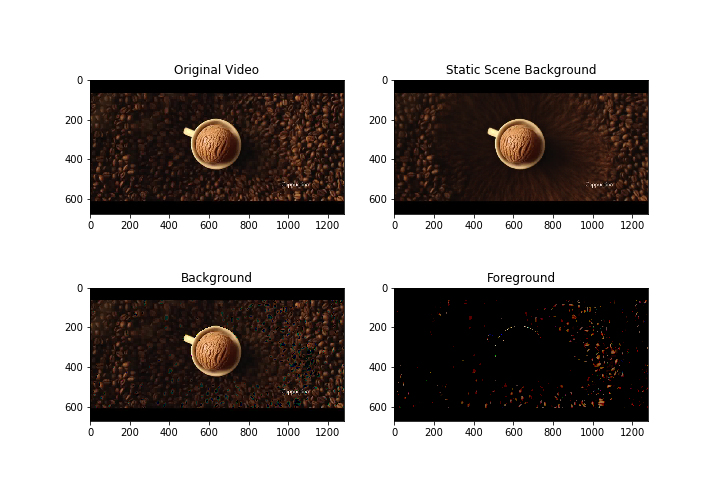

In [201]:
%matplotlib notebook
%matplotlib notebook

f, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0][0].set_title('Original Video')
ax0 = ax[0][0].imshow(images_to_display[0], animated=True)

ax[0][1].set_title('Static Scene Background')
ax1 = ax[0][1].imshow(scene_backg_to_display[0], animated=True)

ax[1][0].set_title('Background')
ax2 = ax[1][0].imshow(backgrounds_to_display[0], animated=True)

ax[1][1].set_title('Foreground')
ax3 = ax[1][1].imshow(foregrounds_to_display[0], animated=True)

def run(i):
    ax0.set_array(images_to_display[i])
    ax1.set_array(scene_backg_to_display[i])
    ax2.set_array(backgrounds_to_display[i])
    ax3.set_array(foregrounds_to_display[i])
    return ax0, ax1, ax2

ani = animation.FuncAnimation(f, run, frames=len(ic), blit=True, interval=10, repeat=False)
plt.show()

- Comment your implementation including details.
- What happens if the shots are not correctly extracted? 
- What happens if you find too many shots in the video? 
- What do the static background images represent? 
- In which situations does the algorithm work and in which it does not? 
- What happens if you substract the background image from the original one?
- Do you see any additional application for this algorithm?

**[OPTIONAL]**
Apply the algorithm to some other static video that you found.

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

- **Comment your implementation including details.**

At first, we applied the algorithm to only some images of each shot, but then we decided to apply it to the whole video for the sake of visualization and clarity.

We start by computing the respective shot medians. For doing so, it is better to firstly transform the image collection into a single numpy array, and then get the median array along the corresponding axis. This median can be considered to be the background. Notice that it is important to perform the right casting, otherwise we will not get the expected result when subtracting (or visualizing).

Then, we subtract the obtained background from the original image. Instead of considering the resulting image as the foreground, we use it to build a mask. This mask, having the same size as the images, will be 1 whenever the corresponding difference is smaller than a certain threshold (we experimented with different values but could not do many tests for computational constraints), and 0 otherwise. The '1's, coming from pixels with small differences, will correspond to the pixels of the background. We later use this mask for setting the pixels of the origina image corresponding to these '1' to 0, and this way we remove the background and leave the foreground.

Notice that in the code of this section we iterave over the indices of the frames corresponding to scene changes, which the code assumes to be correct.

- __What happens if the shots are not correctly extracted?__

The algorithm assumes that its approximation of the background, the median over time of the frames in the shot, is the actual approximation of the background. If the shots are not correctly identified, we will be merging frames from different scenes when computing the median. In this case, the median will not longer be representative of the actual background, and it will not work proprerly.

- **What happens if you find too many shots in the video?**

Suppose that our algorithm for detecting scene changes is way too sensitive and detects multiple _sub-shots_ within a shot, based on some noise. In this case, the median will not be representative of the actual background either. Essentially, what will happen is that some parts of the foreground will part of the background.

- __What do the static background images represent?__

The static background images, computed by taking the median over time (within the shot), represent the parts of the shot that do not change, or at least that change the least (the most frequent values will be kept). The assumption is that the background is the part of a shot that does not change (semantically, this is not exactly true, since we would not consider a quiet dog to be part of the background, for instance, but it is a good approximation).

- **In which situations does the algorithm work and in which it does not?**

As we have said before, there are two assumptions that should hold for the algorithm to work properly:
- The shots should have been detected correctly: Otherwise, we would have the aforementioned problems.
- There are no static foreground images: The static elements are assumed to be part of the background, so the non-moving elements that at least semantically we would consider to be part of the foreground will be still be assigned to be part of the background. For instance, say that a group of humans (foreground) are moving their arms but no their legs, then their legs will be detected as background when computing the median.

- __What happens if you substract the background image from the original one?__

The intuitive idea is that by subtracting the background image from the original one we will get the foreground, since the background image will be present in both itself and the original one, but the foreground will only be present in the original one. However, in practice it is better to use the difference for building a mask (setting to 1 or 0 depending on whether the difference is greater than a certain threshold), and then use the mask to set the corresponding pixels (the background ones) of the original image to 0.

- **Do you see any additional application for this algorithm?**

Yes, anomaly detection. Say that you have a security camera and a computer vision system for automatically surveilling a certain building. The frames will always look very similar. If there is a theft, the foreground will correspond to the thief or the anomaly.

Instead, if we just applied the difference or did not compute the mean, perhaps random noise coming from the camera itself would be detected as an anomaly.
</div>

For the optional exercice, we try to apply it to a secury camera video of a man going out of his house.

## 7.3 Clustering methods on the RGB-XY space

**Hint**: 
- Different image segmentation commands can be found in skimage.segmentation.
- Use the function segmentation.mark_boundaries for seeing the boundaries of the segments.
- Use the inline pluggin to visualize images (%matplotlib inline)
- Add title to the figures to explain what is displayed.

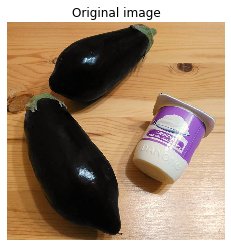

In [205]:
import skimage.segmentation as seg

%matplotlib inline

img = io.imread('images/000000001.jpg')
results = [{
    'img': img,
    'title': 'Original image'
}, None, None, None]

plt.imshow(results[0]['img'])
plt.title(results[0]['title'])
plt.axis('off')
plt.show()

a) Read any image from the folder 'images' and segment it using **Felzenszwalbs's method.**
- Test different parameters in order to obtain a good image segmentation. 
- How does each parameter behave? Which are the optimal values?
- Comment what algorithm is the method based in up to 3 lines most.

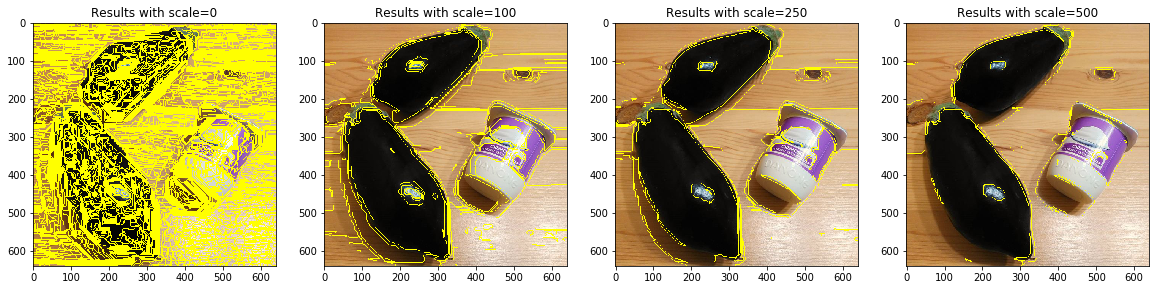

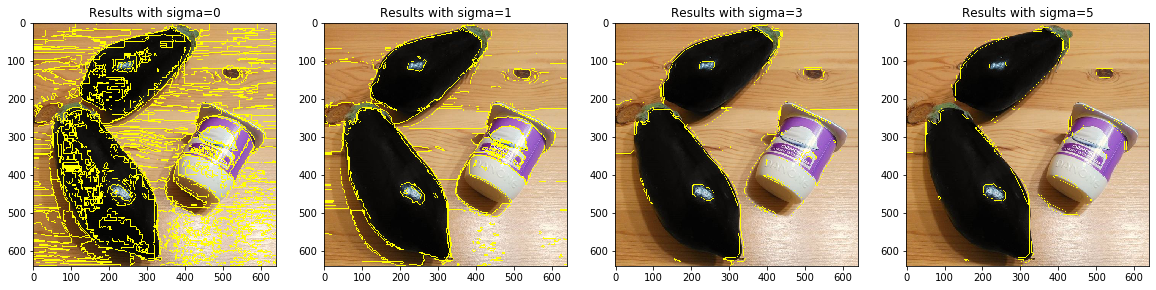

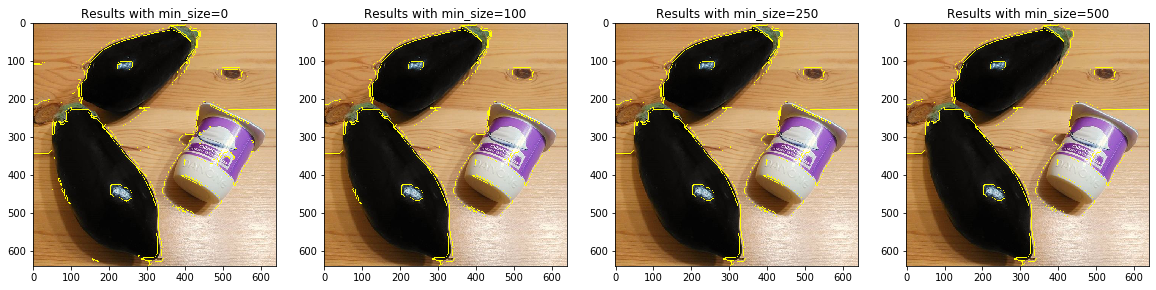

In [241]:
%matplotlib inline

### SCALE

f, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, scale in enumerate([0, 100, 250, 500]):
    segmented_img = seg.felzenszwalb(img, scale=scale)
    marked_boundaries = seg.mark_boundaries(img, segmented_img)
    ax[i].imshow(marked_boundaries)
    ax[i].set_title(f'Results with scale={scale}')

plt.show()

### SIGMA

f, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, sigma in enumerate([0, 1, 3, 5]):
    segmented_img = seg.felzenszwalb(img, scale=500, sigma=sigma)
    marked_boundaries = seg.mark_boundaries(img, segmented_img)
    ax[i].imshow(marked_boundaries)
    ax[i].set_title(f'Results with sigma={sigma}')

plt.show()

### MIN_SIZE

f, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, min_size in enumerate([0, 100, 250, 500]):
    segmented_img = seg.felzenszwalb(img, scale=500, sigma=3, min_size=min_size)
    marked_boundaries = seg.mark_boundaries(img, segmented_img)
    ax[i].imshow(marked_boundaries)
    ax[i].set_title(f'Results with min_size={min_size}')

plt.show()

##########

results[1] = {
    'img': seg.felzenszwalb(img, scale=500, sigma=3, min_size=500),
    'title': 'Segmentation with Felzenszwalb\'s method'
}

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

**Effect of different parameters:**
    
We have three parameters to play with:

- __*scale*__ indicates the scale of the segments to detect, where a large scale means less and larger segments and vice versa. Low values create a lot of small segments that are too noisy to extract any useful information, and too large values lose too much information, opting for a value of *500*.
- __*sigma*__ is used to apply a Gaussian filter in a preprocessing step to smooth the image. With sigma 0 (equivalent to not apply the filter) the background image is so noisy due to the wood line patterns and table brightness. With a large value the image is too blurred and is much more difficult to extract contours. A value that shows good results is to use *3*.
- __*min_size*__ filters in a postprocessing step very small segments, as we can see using *500* which filters small segments detected without this step (min_size=0).
    

**Algorithm base:** 
    
Representing the image as a graph, where the vertices are the pixels and the edges weighted connections between neighbour pixels by their level of dissimilarity using a heuristic which compares the weight to a segment-level threshold, the algorithm builds a multiple MST, forming a forest, each one corresponding to a segment.
   
</div>

b) Segment the previous image using **SLIC algorithm.** 
- Test different parameters in order to obtain a good image segmentation.
- How does each parameter behave? Upto your opinion, which are the optimal values?
- Comment what algorithm is the method based in up to 3 lines.

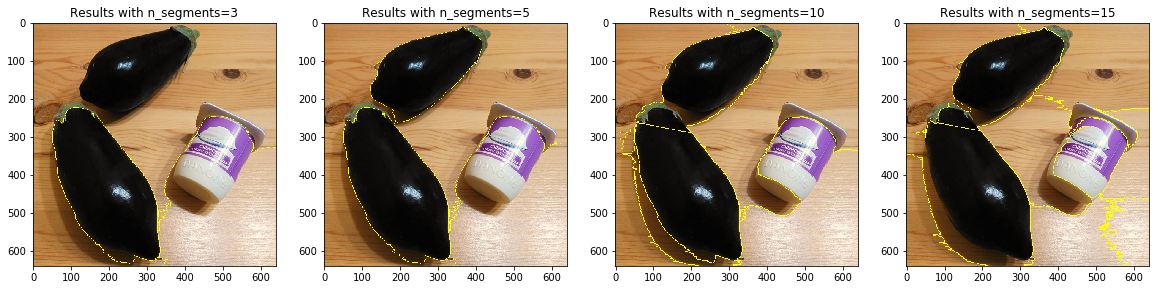

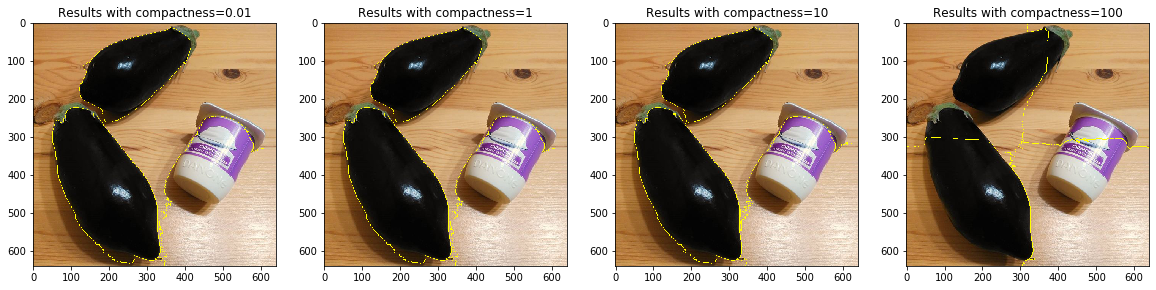

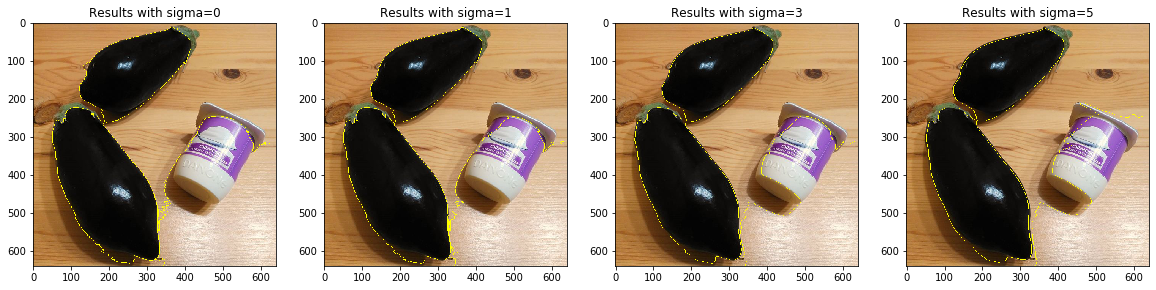

In [247]:
### N_SEGMENTS

f, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, n_segments in enumerate([3, 5, 10, 15]):
    segmented_img = seg.slic(img, n_segments=n_segments)
    marked_boundaries = seg.mark_boundaries(img, segmented_img)
    ax[i].imshow(marked_boundaries)
    ax[i].set_title(f'Results with n_segments={n_segments}')

plt.show()

### COMPACTNESS

f, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, compactness in enumerate([0.01, 1, 10, 100]):
    segmented_img = seg.slic(img, n_segments=5, compactness=compactness)
    marked_boundaries = seg.mark_boundaries(img, segmented_img)
    ax[i].imshow(marked_boundaries)
    ax[i].set_title(f'Results with compactness={compactness}')

plt.show()

### SIGMA

f, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, sigma in enumerate([0, 1, 3, 5]):
    segmented_img = seg.slic(img, n_segments=5, sigma=sigma)
    marked_boundaries = seg.mark_boundaries(img, segmented_img)
    ax[i].imshow(marked_boundaries)
    ax[i].set_title(f'Results with sigma={sigma}')

plt.show()

##########

results[2] = {
    'img': seg.slic(img, n_segments=5, sigma=3),
    'title': 'Segmentation with SLIC algorithm'
}

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

**Effect of different parameters:**
    
We have three parameters to play with:

- __*n_segments*__ are the (approximate) number of labels in the segmented output image. We test values around the expected number of labels, (3, both eggplants and the yogurt). Setting exactly 3 limits the performance detecting less segments. Using a larger value detects more segments but adds a lot of background noise because it tries to find more separations. Hence we decide to set a value slightly higher than 3, *5*.
- __*compactness*__ is a trade-off between color and space proximity. It seems that it doesn't really change the result with small values, so we choose to use the default value *10*, but using too large values (e.g. 100) it produces very poor results.
- __*sigma*__ is used to apply a Gaussian filter in a preprocessing step to smooth the image. With sigma 0 (equivalent to not apply the filter) the background image is so noisy due to the wood line patterns and table brightness. With a large value the image is too blurred and is much more difficult to extract contours. A value that shows good results is to use *3*.
    

**Algorithm base:** 
    
This algorithm segments the image using a K-Means algorithm using as many centroids as the specified #segments using a distance function for spatial and color information that enforces the compactness and regularity of the component superpixel shapes. The spatial distance is weighted by a multiplicative factor.
   
</div>

c) Segment the previous image using **Quickshift algorithm.** 
- Test different parameters in order to obtain a good image segmentation.
- How does each parameter behave? Upto your opinion, which are the optimal values?
- Comment what algorithm is the method based in up to 3 lines.

In [233]:
# TODO: Hyperparameter optimization

##########

results[3] = {
    'img': seg.quickshift(img, kernel_size=15, max_dist=100, sigma=5),
    'title': 'Segmentation with Quickshift algorithm'
}

d) Plot the original image and the results of the above algorithms in a 2x2 subplot.
- Calculate also the number of segments obtained on the image by each of the algorithms.
- Comment the differences between each method as well as their advantages and disadvantages.

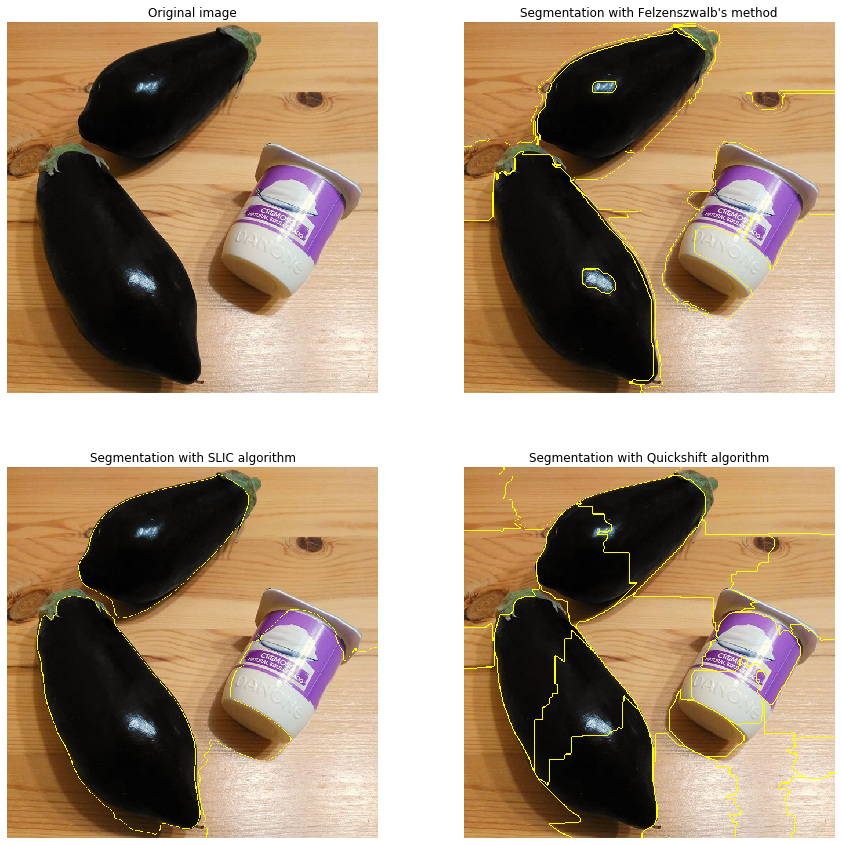

In [248]:
f, ax = plt.subplots(2, 2, figsize=(15, 15))

for idx, segmentation in enumerate(results):
    i, j = divmod(idx, 2)
    if i == 0 and j == 0:
        ax[i, j].imshow(segmentation['img'])
    else:
        segmentation_boundaries = seg.mark_boundaries(results[0]['img'], segmentation['img'])
        ax[i, j].imshow(segmentation_boundaries)
    
    ax[i, j].set_title(segmentation['title'])
    ax[i, j].axis('off')
    
plt.show()

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
</div>